# Anomaly Detection in ICS

In [1]:
# Import libraries
import gzip
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.metrics import Accuracy
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

# Connection with Google Drive
from google.colab import drive 
drive.mount('/content/drive')

# Insert here the path to the dataset on your Google Drive
path = "drive/MyDrive/Cybersecurity UniPD - Magistrale/Primo anno 2022-23/Cyber Physical Systems & IoT Security/Labs/CPS-IoT Lab - Lecture 17/HAI/"

Mounted at /content/drive


In [2]:
# The HAI dataset is already divided into test and train
# but if you want you can try mixing them :)

# Reading two files from the dataset 
with gzip.open(path+'train1.csv.gz', 'rb') as f_in:
    with open(path+'trainFile.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

with gzip.open(path+'test1.csv.gz', 'rb') as f_in:
    with open(path+'testFile.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Train set
dataframe =  pd.read_csv(path+'trainFile.txt')
raw_data = dataframe.values

# Test set
testFrame =  pd.read_csv(path+'testFile.txt')
test_raw_data = testFrame.values

# Look at the structure of the dataset
testFrame.head()

,time,P1_B2004,P1_B2016,P1_B3004,P1_B3005,P1_B4002,P1_B4005,P1_B400B,P1_B4022,P1_FCV01D,...,P4_ST_GOV,P4_ST_LD,P4_ST_PO,P4_ST_PS,P4_ST_PT01,P4_ST_TT01,attack,attack_P1,attack_P2,attack_P3
0,2020-07-07 15:00:00,0.10178,1.58771,403.78854,985.37353,32.59527,100.0,2839.58520,36.81010,100.0,...,20469.0,386.26666,380.31683,0,10044.0,27567.0,0,0,0,0
1,2020-07-07 15:00:01,0.10178,1.58725,403.78854,985.37353,32.59527,100.0,2843.37549,36.80895,100.0,...,20489.0,386.30286,380.02747,0,10040.0,27564.0,0,0,0,0
2,2020-07-07 15:00:02,0.10178,1.59519,403.78854,985.37353,32.59527,100.0,2845.06006,36.82879,100.0,...,20604.0,389.73883,381.52850,0,10037.0,27565.0,0,0,0,0
3,2020-07-07 15:00:03,0.10178,1.59747,403.78854,985.37353,32.59527,100.0,2837.33911,36.83451,100.0,...,20633.0,388.94311,382.08911,0,10040.0,27560.0,0,0,0,0
4,2020-07-07 15:00:04,0.10178,1.59869,403.78854,985.37353,32.59527,100.0,2843.37549,36.83756,100.0,...,20738.0,389.72082,383.44543,0,10042.0,27564.0,0,0,0,0


In [3]:
# Preprocessing 
test_attack = testFrame[testFrame['attack']==1].values
test_normal = testFrame[testFrame['attack']==0].values

# Remove timestamps and labels
X_train = raw_data[:, 1:-4] # train_data
X_test = test_raw_data[:, 1:-4] # test_data
test_attack = test_attack[:, 1:-4]

# Get the list of labels 
y_test = testFrame['attack'] # test_labels
unique, counts = np.unique(np.array(y_test), return_counts=True)

# Print the results in a formatted table
print("Test data distribution:")
print("{:<15} {:<10}".format('Attack', 'Count'))
print("--------------------------")
for i in range(len(unique)):
    print("{:<15} {:<10}".format(unique[i], counts[i]))

Test data distribution:
Attack          Count     
--------------------------
0               42572     
1               629       


In [4]:
# Data normalization with minmax
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

# Test anomalous data
test_attack_normalized = MinMaxScaler().fit_transform(test_attack)

<function matplotlib.pyplot.show(close=None, block=None)>

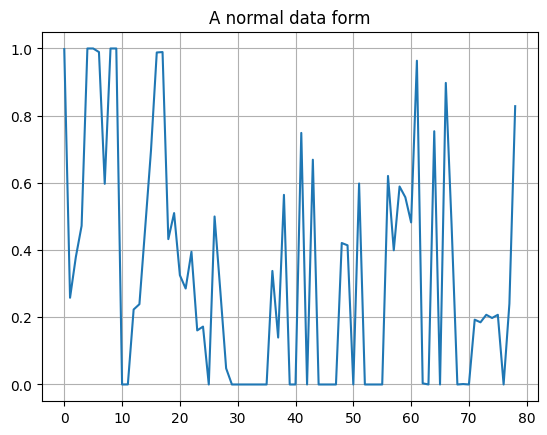

In [5]:
# How does a normal process look like?
plt.grid()
plt.plot(np.arange(79), X_train[35])
plt.title("A normal data form")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

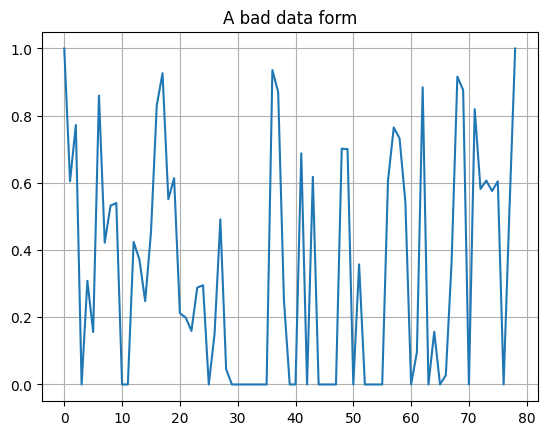

In [6]:
# Instead, how does a bad process look like?
plt.grid()
plt.plot(np.arange(79), test_attack_normalized[0])
plt.title("A bad data form")
plt.show

In [7]:
# Here we define our autoencoder model using Keras models
# You can try to modify/add some layers to see if you can achieve better performances

class Anomaly(Model):
  def __init__(self):
    super(Anomaly, self).__init__()
    self.encoder = Sequential([
                               Dense(32, activation='relu'),
                               Dense(16, activation='relu'),
                               Dense(8, activation='relu')
    ])

    self.decoder = Sequential([
                               Dense(8, activation='relu'),
                               Dense(16, activation='relu'),
                               Dense(32, activation='relu'),
                               # output with the correct number of features 
                               Dense(79, activation='sigmoid') 
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Anomaly()

In [8]:
# Then, we compile the autoencoder 
autoencoder.compile(optimizer='adam', loss='mae')

In [9]:
# Training the model using early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = autoencoder.fit(X_train, 
                          X_train,
                          epochs=20,
                          validation_data=(X_test, X_test),
                          shuffle=True,
                          callbacks=[callback])

Epoch 1/20
6751/6751 [==============================] - 23s 3ms/step - loss: 0.0690 - val_loss: 0.1206
Epoch 2/20
6751/6751 [==============================] - 22s 3ms/step - loss: 0.0524 - val_loss: 0.1159
Epoch 3/20
6751/6751 [==============================] - 21s 3ms/step - loss: 0.0495 - val_loss: 0.1137
Epoch 4/20
6751/6751 [==============================] - 21s 3ms/step - loss: 0.0484 - val_loss: 0.1160
Epoch 5/20
6751/6751 [==============================] - 26s 4ms/step - loss: 0.0475 - val_loss: 0.1180
Epoch 6/20
6751/6751 [==============================] - 21s 3ms/step - loss: 0.0471 - val_loss: 0.1148
Epoch 7/20
6751/6751 [==============================] - 22s 3ms/step - loss: 0.0469 - val_loss: 0.1148
Epoch 8/20
6751/6751 [==============================] - 21s 3ms/step - loss: 0.0466 - val_loss: 0.1161
Epoch 9/20
6751/6751 [==============================] - 23s 3ms/step - loss: 0.0453 - val_loss: 0.1154
Epoch 10/20
6751/6751 [==============================] - 20s 3ms/step - l

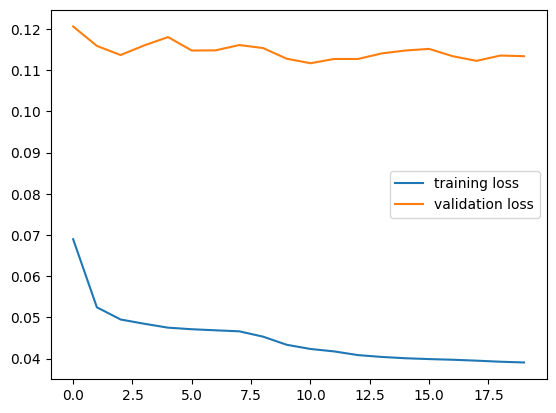

In [10]:
# Printing the scores of the training process
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()

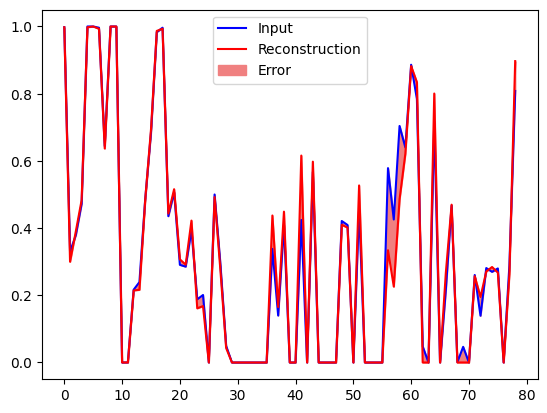

In [11]:
# Let's have a visual look of how our model is able to reconstruct normal data
X_train = np.asarray(X_train).astype('float32')
encoded_img = autoencoder.encoder(X_train)
decoded_img = autoencoder.decoder(encoded_img)

plt.plot(X_train[0], 'b')
plt.plot(decoded_img[0], 'r')
plt.fill_between(np.arange(79), decoded_img[0], X_train[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

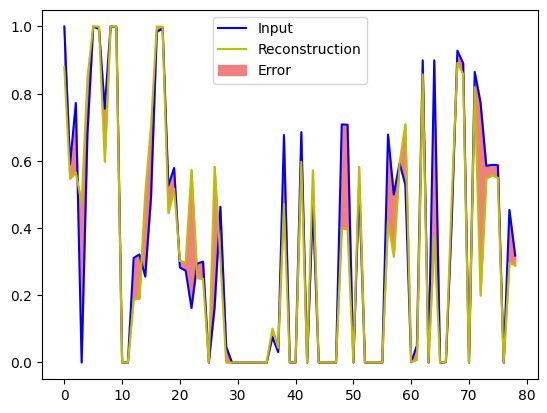

In [12]:
# For anomalous data, let see if the error is higher
test_attack = np.asarray(X_test).astype('float32')
encoded_attack_img = autoencoder.encoder(test_attack)
decoded_attack_img = autoencoder.decoder(encoded_attack_img)

plt.plot(test_attack[0], 'b')
plt.plot(decoded_attack_img[0], 'y')
plt.fill_between(np.arange(79), decoded_attack_img[0], X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

# As we can see at the graph, our model tries to recostruct the anomalous data but with a very high error rate

In [13]:
# Let's compute the reconstruction Mean absolute error for each sample in the training set! 
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

# The we use the stdev of the reconsutrction error on the normal data as threshold
# If the error is bigger than it, we would detect an anomaly
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)    

6751/6751 [==============================] - 12s 2ms/step
Threshold:  0.05235544


In [14]:
# Let's try with the test data to see how good is our model
reconstructions = autoencoder(X_test)
loss = tf.keras.losses.mae(reconstructions, X_test)
preds = tf.math.less(loss, threshold)

# Finally compute the accuracy 
score = accuracy_score(y_test, preds)
print('Accuracy: %.8f' % score)

Accuracy: 0.98544015




---

